In [1]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 9.7 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
from arch import arch_model
import matplotlib.pyplot as plt

# Define a ticker and a date range for your data
ticker = 'SPY'  # S&P 500 ETF, a good proxy for the market
start_date = '2010-01-01'
end_date = '2025-07-31'

# Download historical data from Yahoo Finance
# We will explicitly use auto_adjust=True to get the adjusted closing prices.
data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)

display(data)

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2010-01-04,85.515617,85.560890,84.142297,84.791229,118944600
2010-01-05,85.741959,85.779689,85.153394,85.462771,111579900
2010-01-06,85.802353,86.013632,85.591074,85.658982,116074400
2010-01-07,86.164551,86.270190,85.402432,85.643894,131091100
2010-01-08,86.451263,86.488994,85.764606,85.938155,126402800
...,...,...,...,...,...
2025-07-24,634.419983,636.150024,633.989990,634.599976,71307100
2025-07-25,637.099976,637.580017,634.840027,635.090027,56865400


Data for SPY from 2010-01-01 to 2025-07-31
--------------------------------------------------
Ticker          SPY
count   3916.000000
mean       0.051177
std        1.094580
min      -11.588643
25%       -0.371736
50%        0.069393
75%        0.578568
max        9.986286
--------------------------------------------------


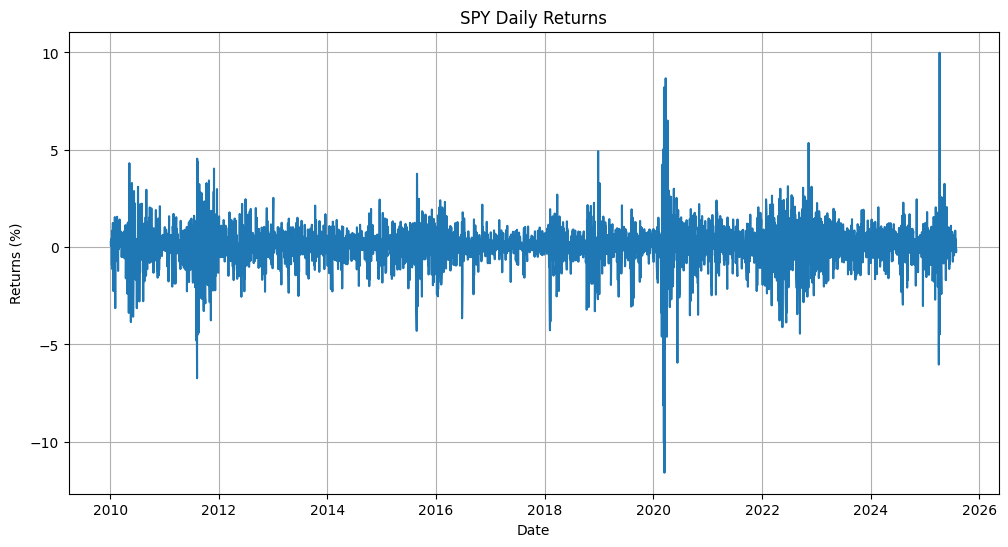

In [3]:
# Calculate logarithmic returns
# GARCH models are typically applied to returns, not raw prices.
# Log returns are often preferred as they are time-additive and more symmetric.
# Calculate logarithmic returns
returns = 100 * np.log(data['Close'] / data['Close'].shift(1)).dropna()

# Print a summary of the data
print(f"Data for {ticker} from {start_date} to {end_date}")
print("-" * 50)
print(returns.describe())
print("-" * 50)

# Optional: Plot the returns to visualize volatility clustering
plt.figure(figsize=(12, 6))
plt.plot(returns)
plt.title(f'{ticker} Daily Returns')
plt.ylabel('Returns (%)')
plt.xlabel('Date')
plt.grid(True)
plt.show()

In [4]:
# Assuming your 'returns' series is from the previous step
# Define a split date for your training and testing sets
split_date = '2024-07-31'  # Example: use the last year for testing

# Split the data
train_returns = returns[returns.index <= split_date]
test_returns = returns[returns.index > split_date]

print(f"Training data size: {len(train_returns)} observations")
print(f"Testing data size: {len(test_returns)} observations")

Training data size: 3667 observations
Testing data size: 249 observations


                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                    SPY   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -4622.34
Distribution:                  Normal   AIC:                           9254.68
Method:            Maximum Likelihood   BIC:                           9285.71
                                        No. Observations:                 3667
Date:                Fri, Aug 01 2025   Df Residuals:                     3666
Time:                        21:44:33   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0521  1.184e-02      4.396  1.104e-05 [2.

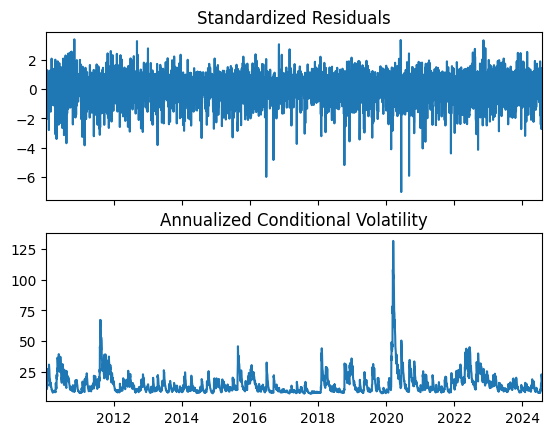

In [5]:
# Create a GJR-GARCH model
# This uses a Glosten-Jagannathan-Runkle GARCH (GJR-GARCH) model with a constant mean.
# GJR-GARCH is an asymmetric model that captures the "leverage effect,"
# where negative returns have a greater impact on volatility than positive returns of the same magnitude.

# The GJR-GARCH model's asymmetry is captured by the 'o' parameter.
# A p=1, o=1, q=1 model is a common and effective choice.

# Fit the GJR-GARCH(1,1) model on the training data
# vol='Garch' is used, with the asymmetry specified by o=1.

am_train = arch_model(train_returns, vol='Garch', p=1, o=1, q=1, mean='Constant')
res_train = am_train.fit(disp='off')

# Print the summary of the trained model to see its coefficients
print(res_train.summary())

# Plot the conditional volatility from the model
fig = res_train.plot(annualize='D')

--- Forecast Performance Metrics ---
Mean Squared Error (MSE): 0.900774
Mean Absolute Error (MAE): 0.641340
R-squared (R²): 0.088907


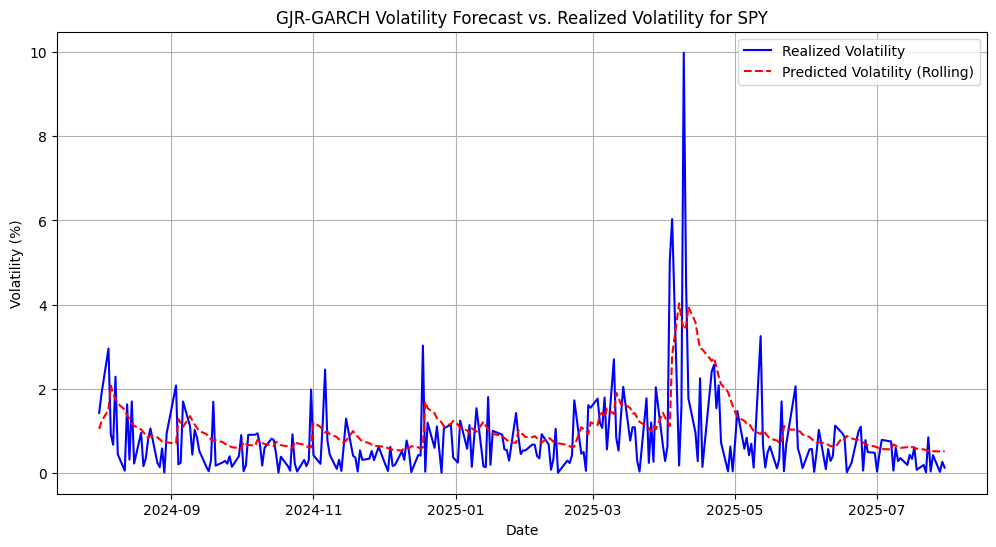

In [6]:
# --- GJR-GARCH Rolling Forecast Implementation ---

# Create a list to store the rolling one-day-ahead volatility forecasts
rolling_forecasts = []

# Loop through the test data, simulating a walk-forward process
for i in range(len(test_returns)):
    # Define the current training window
    # The training window grows by one observation in each iteration
    current_train_returns = returns[:len(train_returns) + i]

    # Fit the GJR-GARCH(1,1) model with a constant mean on the current training window.
    # The 'o' parameter is added to capture the asymmetric leverage effect.
    am_rolling = arch_model(current_train_returns, vol='Garch', p=1, o=1, q=1, mean='Constant')
    res_rolling = am_rolling.fit(disp='off')

    # Use the model to forecast the conditional variance for the next day (horizon=1)
    one_day_forecast = res_rolling.forecast(horizon=1)

    # Extract the predicted conditional volatility for the next day
    predicted_vol = np.sqrt(one_day_forecast.variance.iloc[-1].values[0])

    # Append the forecast to our list
    rolling_forecasts.append(predicted_vol)


# --- Data Preparation for Analysis and Plotting ---

# Convert the list of forecasts into a pandas Series
# We use the index from the test_returns to align the forecasts correctly
predicted_volatility_rolling = pd.Series(rolling_forecasts, index=test_returns.index)

# The realized volatility is simply the absolute value of the test returns
realized_volatility = np.abs(test_returns)

# --- Quantitative Analysis ---
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate the error metrics
mse = mean_squared_error(realized_volatility, predicted_volatility_rolling)
mae = mean_absolute_error(realized_volatility, predicted_volatility_rolling)
r2 = r2_score(realized_volatility, predicted_volatility_rolling)

print("--- Forecast Performance Metrics ---")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R-squared (R²): {r2:.6f}")

# --- Plotting the Results ---

# Plot the results using the same logic as before
plt.figure(figsize=(12, 6))
plt.plot(realized_volatility, label='Realized Volatility', color='blue')
plt.plot(predicted_volatility_rolling, label='Predicted Volatility (Rolling)', color='red', linestyle='--')
plt.title(f'GJR-GARCH Volatility Forecast vs. Realized Volatility for {ticker}')
plt.ylabel('Volatility (%)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

--- Forecast Performance Metrics ---
Mean Squared Error (MSE): 0.916879
Mean Absolute Error (MAE): 0.650122
R-squared (R²): 0.072617


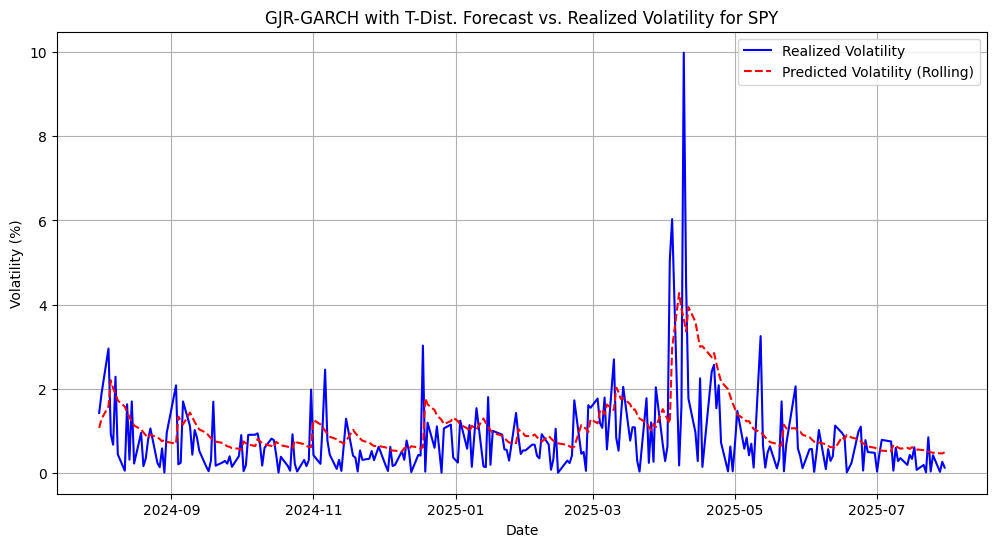

In [7]:
# --- GJR-GARCH with Student's T Rolling Forecast Implementation ---

# Create a list to store the rolling one-day-ahead volatility forecasts
rolling_forecasts = []

# Loop through the test data, simulating a walk-forward process
for i in range(len(test_returns)):
    # Define the current training window
    # The training window grows by one observation in each iteration
    current_train_returns = returns[:len(train_returns) + i]

    # Fit the GJR-GARCH(1,1) model with a Student's t-distribution
    # The 'dist' parameter is added to capture the fat-tailed nature of returns.
    am_rolling = arch_model(current_train_returns, vol='Garch', p=1, o=1, q=1, mean='Constant', dist='t')
    res_rolling = am_rolling.fit(disp='off')

    # Use the model to forecast the conditional variance for the next day (horizon=1)
    one_day_forecast = res_rolling.forecast(horizon=1)

    # Extract the predicted conditional volatility for the next day
    predicted_vol = np.sqrt(one_day_forecast.variance.iloc[-1].values[0])

    # Append the forecast to our list
    rolling_forecasts.append(predicted_vol)


# --- Data Preparation for Analysis and Plotting ---

# Convert the list of forecasts into a pandas Series
predicted_volatility_rolling = pd.Series(rolling_forecasts, index=test_returns.index)

# The realized volatility is simply the absolute value of the test returns
realized_volatility = np.abs(test_returns)

# --- Quantitative Analysis ---
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate the error metrics
mse = mean_squared_error(realized_volatility, predicted_volatility_rolling)
mae = mean_absolute_error(realized_volatility, predicted_volatility_rolling)
r2 = r2_score(realized_volatility, predicted_volatility_rolling)

print("--- Forecast Performance Metrics ---")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R-squared (R²): {r2:.6f}")

# --- Plotting the Results ---

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(realized_volatility, label='Realized Volatility', color='blue')
plt.plot(predicted_volatility_rolling, label='Predicted Volatility (Rolling)', color='red', linestyle='--')
plt.title(f'GJR-GARCH with T-Dist. Forecast vs. Realized Volatility for {ticker}')
plt.ylabel('Volatility (%)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

## Testing the GJR-GARCH model with different Hyper-Parameter values

Tuning GJR-GARCH hyperparameters on training data...
GJR-GARCH Hyperparameter Tuning Results (Sorted by BIC):
   p  o  q          BIC
0  1  1  1  9285.713363
2  2  1  1  9291.520079
1  1  1  2  9293.920492
3  2  1  2  9299.727207

Best GJR-GARCH order found: p=1, o=1, q=1 with BIC=9285.7134

--- Forecast Performance Metrics ---
Mean Squared Error (MSE): 0.900774
Mean Absolute Error (MAE): 0.641340
R-squared (R²): 0.088907


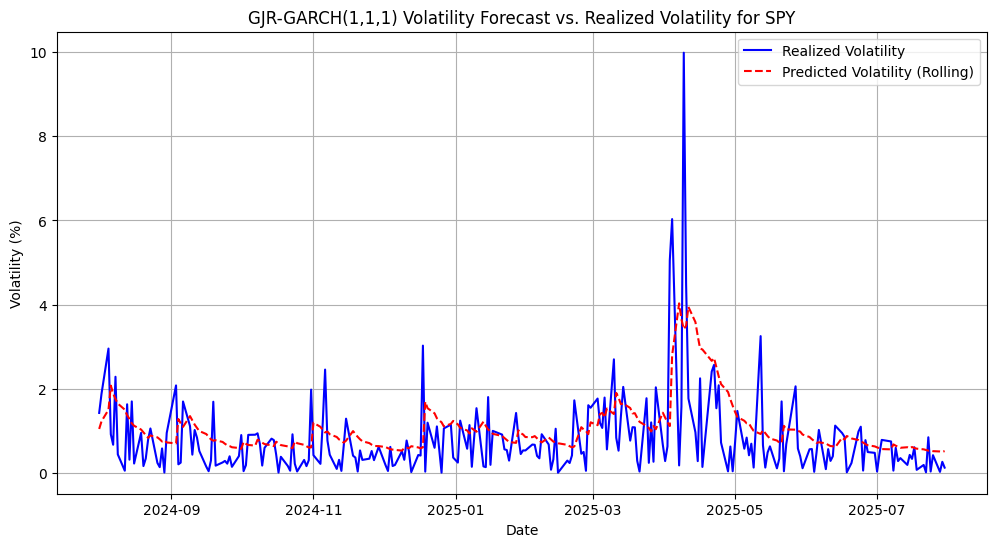

In [9]:
# --- GJR-GARCH with Hyperparameter Tuning and Rolling Forecast ---
import pandas as pd
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Find the best GJR-GARCH order (p, o, q) on the training data ---
print("Tuning GJR-GARCH hyperparameters on training data...")

# Define the range of p, o, q values to test
p_orders = range(1, 3)
o_orders = range(1, 2)
q_orders = range(1, 3)

best_bic = np.inf
best_p, best_o, best_q = 0, 0, 0

# Create an empty list to store the results
results_list = []

# Loop through all possible combinations of p, o, and q
for p in p_orders:
    for o in o_orders:
        for q in q_orders:
            try:
                # Fit the GJR-GARCH model with the current p, o, q
                model = arch_model(train_returns, vol='Garch', p=p, o=o, q=q, mean='Constant')
                res = model.fit(disp='off')

                # Append the results to the list
                results_list.append({
                    'p': p,
                    'o': o,
                    'q': q,
                    'BIC': res.bic
                })
            except:
                continue

# Convert the results list to a DataFrame and sort by BIC
results_df = pd.DataFrame(results_list).sort_values(by='BIC')

# Print the results table
print("GJR-GARCH Hyperparameter Tuning Results (Sorted by BIC):")
print(results_df)

# Extract the best parameters from the top row of the sorted DataFrame
best_p = int(results_df.iloc[0]['p'])
best_o = int(results_df.iloc[0]['o'])
best_q = int(results_df.iloc[0]['q'])

print(f"\nBest GJR-GARCH order found: p={best_p}, o={best_o}, q={best_q} with BIC={results_df.iloc[0]['BIC']:.4f}\n")

# --- Step 2: GJR-GARCH Rolling Forecast Implementation with the best hyperparameters ---

# Create a list to store the rolling one-day-ahead volatility forecasts
rolling_forecasts = []

# Loop through the test data, simulating a walk-forward process
for i in range(len(test_returns)):
    # Define the current training window
    current_train_returns = returns[:len(train_returns) + i]

    # Fit the GJR-GARCH model with the best p, o, q order found above.
    am_rolling = arch_model(current_train_returns, vol='Garch', p=best_p, o=best_o, q=best_q, mean='Constant')
    res_rolling = am_rolling.fit(disp='off')

    # Use the model to forecast the conditional variance for the next day (horizon=1)
    one_day_forecast = res_rolling.forecast(horizon=1)

    # Extract the predicted conditional volatility for the next day
    predicted_vol = np.sqrt(one_day_forecast.variance.iloc[-1].values[0])

    # Append the forecast to our list
    rolling_forecasts.append(predicted_vol)


# --- Data Preparation for Analysis and Plotting ---
predicted_volatility_rolling = pd.Series(rolling_forecasts, index=test_returns.index)
realized_volatility = np.abs(test_returns)

# --- Quantitative Analysis ---
mse = mean_squared_error(realized_volatility, predicted_volatility_rolling)
mae = mean_absolute_error(realized_volatility, predicted_volatility_rolling)
r2 = r2_score(realized_volatility, predicted_volatility_rolling)

print("--- Forecast Performance Metrics ---")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R-squared (R²): {r2:.6f}")

# --- Plotting the Results ---
plt.figure(figsize=(12, 6))
plt.plot(realized_volatility, label='Realized Volatility', color='blue')
plt.plot(predicted_volatility_rolling, label='Predicted Volatility (Rolling)', color='red', linestyle='--')
plt.title(f'GJR-GARCH({best_p},{best_o},{best_q}) Volatility Forecast vs. Realized Volatility for {ticker}')
plt.ylabel('Volatility (%)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()